In [1]:
from principal_RBM_alpha import * 
from principal_DBN_alpha import * 
from principal_DNN_MNIST import * 
import torch
import numpy as np
from time import time
from tqdm import tqdm
import torchvision

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

### Visualisation du préentrainement d'une RBM sur BinaryAlphaDigits

Nous allons visualiser l'entrainement de notre RBM sur la base de données BinaryAlphadigits. Dans un premier temps, on considère le préentrainement sur le nombre $8$

In [3]:
index = 10
X  = lire_alpha_digit(index, device)

In [4]:
print('Les données contiennent:')
print(f'{X.size(0)} examples')
print(f'{X.size(1)} pixels')


Les données contiennent:
39 examples
320 pixels


In [5]:

p = X.size(1) #Nombre de pixels
qs = [10,100,500] #Test de différents nombres de neuronnes dans la couche cachée
batch_size = 10 #Le nombre de données par batch
lr = 0.1 #Le pas dans la gradient ascent
epochs = 1000 #Le nombre d'itérations (nombre de fois que le modèle voit toutes les données)
n_images = 2 #Nombre d'images à générer une fois la RBM entrainée
gibbs_iter = 1000 #Nombre d'itération dans le gibbs sampler pour générer une image

historique = []
images_RBM = []
times_RBM = []

for q in qs : 
    t0 = time()
    print(f'RBM avec {q} neuronnes')
    RBM = init_RBM(p, q, device)
    trained_RBM, history = train_RBM(X, RBM, epochs, lr, batch_size)
    historique.append(history)
    gen_images = generer_image_RBM(trained_RBM, gibbs_iter, n_images, plot = False)
    print('')
    times_RBM.append(time()-t0)
    images_RBM.append(gen_images)

RBM avec 10 neuronnes


EPOCH 999 - Reconstruction Error: 21.3517: 100%|█| 1000/1000 [00:04<00:00, 206.6



RBM avec 100 neuronnes


EPOCH 999 - Reconstruction Error: 0.0289: 100%|█| 1000/1000 [00:05<00:00, 190.77



RBM avec 500 neuronnes


EPOCH 999 - Reconstruction Error: 0.0010: 100%|█| 1000/1000 [00:05<00:00, 183.09


In [6]:
print(f'Training time (GPU) 10 neuronnes: {times_RBM[0]:0.3f} seconds')
print(f'Training time (GPU) 100 neuronnes: {times_RBM[1]:0.3f} seconds')
print(f'Training time (GPU) 500 neuronnes: {times_RBM[2]:0.3f} seconds')

Training time (GPU) 10 neuronnes: 5.137 seconds
Training time (GPU) 100 neuronnes: 5.569 seconds
Training time (GPU) 500 neuronnes: 5.826 seconds


Le temps d'entraînement n'augmente presque pas avec le nombre de neuronnes. Cela est probablement du à l'utilisation du GPU par Pytorch

Text(0, 0.5, 'Reconstruction Error')

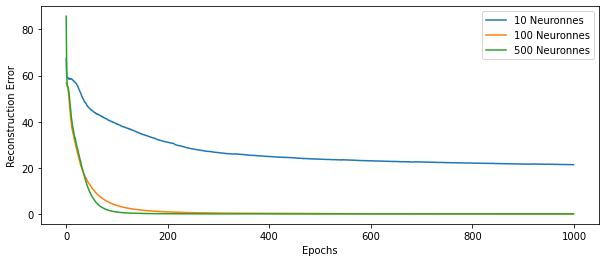

In [7]:
plt.figure(figsize = (10,4))
plt.plot(historique[0], label = '10 Neuronnes')
plt.plot(historique[1], label = '100 Neuronnes')
plt.plot(historique[2], label = '500 Neuronnes')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')


Nous voyons qu'une RBM avec 10 neuronnes ne convergent pas, tandis qu'une RBM avec 100 ou 500 neuronnes convergent vers une erreur de reconstruction très faible. Par ailleurs, l'utilisation de 500 neuronnes permet une convergence plus rapide.

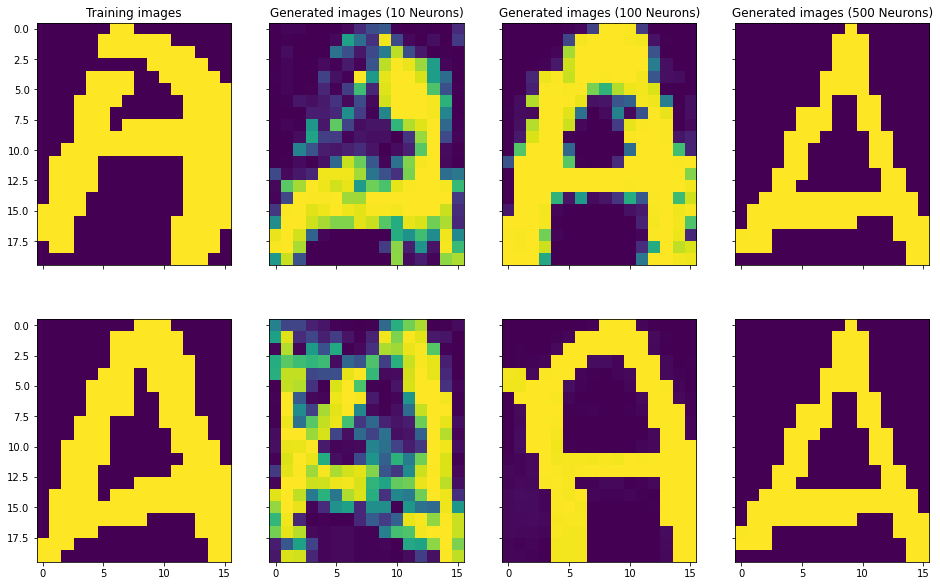

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, sharex = True, sharey = True, figsize = (16,10))

ax[0,0].imshow(X[0].view(20,16).cpu().numpy())
ax[1,0].imshow(X[10].view(20,16).cpu().numpy())
ax[0,0].set_title('Training images')

ax[0,1].imshow(images_RBM[0][0])
ax[1,1].imshow(images_RBM[0][1])
ax[0,1].set_title('Generated images (10 Neurons)')

ax[0,2].imshow(images_RBM[1][0])
ax[1,2].imshow(images_RBM[1][1])
ax[0,2].set_title('Generated images (100 Neurons)')

ax[0,3].imshow(images_RBM[2][0])
ax[1,3].imshow(images_RBM[2][1])
_=ax[0,3].set_title('Generated images (500 Neurons)')


Les RBM avec 100 et 500 neuronnes génèrent des images aussi proche que celles utilisées pourt l'entraînement.

### Visualisation du préentrainement d'un DBN sur BinaryAlphaDigits

In [9]:

p = X.size(1) #Nombre de pixels
qs = [100,500] #Test de différents nombres de neuronnes dans la couche cachée
n_layers = [2,5]
batch_size = 10 #Le nombre de données par batch
lr = 0.1 #Le pas dans la gradient ascent
epochs = 1000 #Le nombre d'itérations (nombre de fois que le modèle voit toutes les données)
n_images = 2 #Nombre d'images à générer une fois la RBM entrainée
gibbs_iter = 1000 #Nombre d'itération dans le gibbs sampler pour générer une image

images_DBN = []
times_DBN = []

for q in qs : 
    for n in n_layers : 
        t0 = time()
        print(f'DBN avec {n} couches de {q} neuronnes')
        sizes = [(X.size(1), q)]
        for j in range(n) : 
            sizes.append((q, q)) 
        DNN = init_DNN(len(sizes), sizes, device)
        trained_DNN = pretrain_DNN(
             X, DNN, epochs, lr, batch_size
         )
        gen_images = generer_image_DBN(trained_DNN, gibbs_iter, n_images, plot = False)
        print('')
        times_DBN.append(time()-t0)
        images_DBN.append(gen_images)

DBN avec 2 couches de 100 neuronnes


EPOCH 999 - Reconstruction Error: 0.0239: 100%|█| 1000/1000 [00:04<00:00, 202.83
EPOCH 999 - Reconstruction Error: 0.0042: 100%|█| 1000/1000 [00:04<00:00, 200.25



DBN avec 5 couches de 100 neuronnes


EPOCH 999 - Reconstruction Error: 0.0273: 100%|█| 1000/1000 [00:05<00:00, 182.30
EPOCH 999 - Reconstruction Error: 0.0043: 100%|█| 1000/1000 [00:05<00:00, 173.31
EPOCH 999 - Reconstruction Error: 0.0030: 100%|█| 1000/1000 [00:05<00:00, 199.29
EPOCH 999 - Reconstruction Error: 0.0021: 100%|█| 1000/1000 [00:05<00:00, 199.38
EPOCH 999 - Reconstruction Error: 0.0018: 100%|█| 1000/1000 [00:04<00:00, 212.72



DBN avec 2 couches de 500 neuronnes


EPOCH 999 - Reconstruction Error: 0.0010: 100%|█| 1000/1000 [00:05<00:00, 197.61
EPOCH 999 - Reconstruction Error: 0.0004: 100%|█| 1000/1000 [00:05<00:00, 186.41



DBN avec 5 couches de 500 neuronnes


EPOCH 999 - Reconstruction Error: 0.0010: 100%|█| 1000/1000 [00:05<00:00, 194.95
EPOCH 999 - Reconstruction Error: 0.0004: 100%|█| 1000/1000 [00:05<00:00, 198.25
EPOCH 999 - Reconstruction Error: 0.0002: 100%|█| 1000/1000 [00:05<00:00, 190.80
EPOCH 999 - Reconstruction Error: 0.0003: 100%|█| 1000/1000 [00:05<00:00, 190.70
EPOCH 999 - Reconstruction Error: 0.0002: 100%|█| 1000/1000 [00:05<00:00, 182.67


In [10]:
print(f'Training time (GPU) 2 couches - 100 neuronnes: {times_DBN[0]:0.3f} seconds')
print(f'Training time (GPU) 5 couches - 100 neuronnes: {times_DBN[1]:0.3f} seconds')
print(f'Training time (GPU) 2 couches - 500 neuronnes: {times_DBN[2]:0.3f} seconds')
print(f'Training time (GPU) 5 couches - 500 neuronnes: {times_DBN[3]:0.3f} seconds')

Training time (GPU) 2 couches - 100 neuronnes: 11.219 seconds
Training time (GPU) 5 couches - 100 neuronnes: 28.347 seconds
Training time (GPU) 2 couches - 500 neuronnes: 11.742 seconds
Training time (GPU) 5 couches - 500 neuronnes: 28.509 seconds


Le temps d'entraînement semble augmenter linéairement avec le nombre de couches. Cependant, le nombre de neuronnes ne l'affecte pas beaucoup 

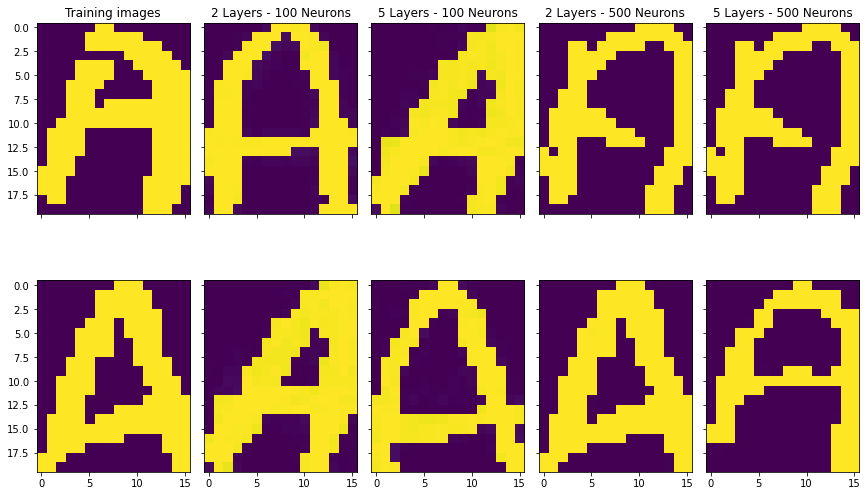

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True, figsize = (12,8))

ax[0,0].imshow(X[0].view(20,16).cpu().numpy())
ax[1,0].imshow(X[10].view(20,16).cpu().numpy())
ax[0,0].set_title('Training images')

ax[0,1].imshow(images_DBN[0][0])
ax[1,1].imshow(images_DBN[0][1])
ax[0,1].set_title('2 Layers - 100 Neurons')

ax[0,2].imshow(images_DBN[1][0])
ax[1,2].imshow(images_DBN[1][1])
ax[0,2].set_title('5 Layers - 100 Neurons')

ax[0,3].imshow(images_DBN[2][0])
ax[1,3].imshow(images_DBN[2][1])
ax[0,3].set_title('2 Layers - 500 Neurons')

ax[0,4].imshow(images_DBN[3][0])
ax[1,4].imshow(images_DBN[3][1])
_ = ax[0,4].set_title('5 Layers - 500 Neurons')
plt.tight_layout()

##### Génération d'Image pour le rapport

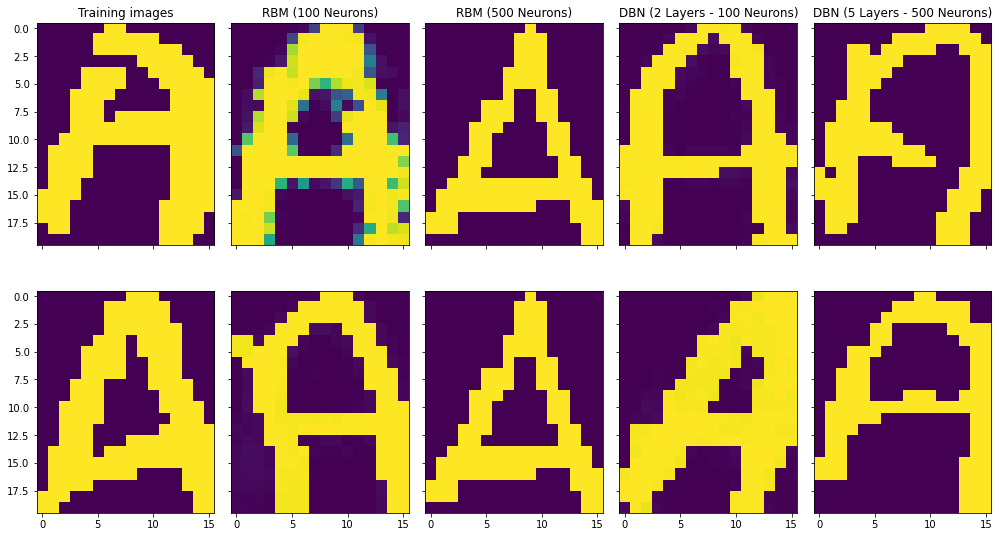

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True, figsize = (14,8))

ax[0,0].imshow(X[0].view(20,16).cpu().numpy())
ax[1,0].imshow(X[10].view(20,16).cpu().numpy())
ax[0,0].set_title('Training images')

ax[0,1].imshow(images_RBM[1][0])
ax[1,1].imshow(images_RBM[1][1])
ax[0,1].set_title('RBM (100 Neurons)')

ax[0,2].imshow(images_RBM[2][0])
ax[1,2].imshow(images_RBM[2][1])
_=ax[0,2].set_title('RBM (500 Neurons)')

ax[0,3].imshow(images_DBN[0][0])
ax[1,3].imshow(images_DBN[0][1])
ax[0,3].set_title('DBN (2 Layers - 100 Neurons)')

ax[0,4].imshow(images_DBN[3][0])
ax[1,4].imshow(images_DBN[3][1])
_ = ax[0,4].set_title('DBN (5 Layers - 500 Neurons)')
plt.tight_layout()

plt.savefig('figures/image_generation_rbm_dbn.jpg', dpi=300)

### Classfication avec un DNN

Pour la classification, on considère le dataset MNIST contenant des images en $28\times28$ pixels représentant des chiffres de $0$ à $9$. On possède $60000$ images pour l'entrainement et $10000$ images pour tester la généralisation de notre modèle.

On va utiliser un DNN - un DBN contenant une couche de classification supplémentaire. On divise le jeu en jeu d'entraînement (train), validation (pour déterminer un critère d'arrêt d'entrainement) et de test. On utilisera $5\%$ du jeu d'entrainement en tant que jeu de validation pour la dernière partie consistant à trouver le meilleure jeu d'hyperparamètres.

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = lire_mnist(device = device, val_size = 0)

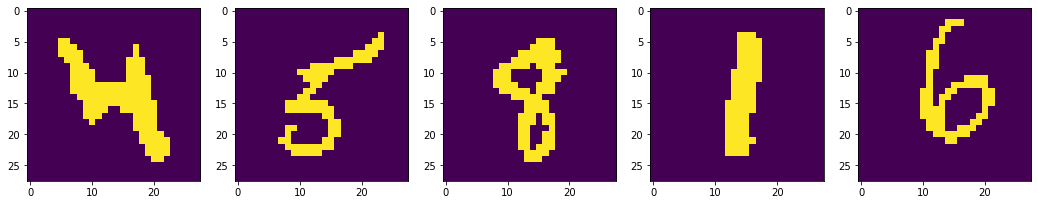

In [14]:
fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (18,12))

for j in range(5) : 
    ax[j].imshow(X_train[np.random.randint(X_train.size(0))].reshape(28,28).cpu().numpy())

On s'intéresse à deux types de **DNN*: 

- Un **DNN** préentrainé: on performe dans un premier temps un entrainement non supervisé de toutes les couches (hors couche de classification) du DNN de la même manière que l'on a entrainé le DBN. On entraine ensuite le **DNN** en utilisant l'alogrithme de rétropropagation.
- Un **DNN** initalisé aléatoirement, entrainé avec l'alogrithme de rétropropagation.

Dans les deux cas, les **DNN** seront initialisés avec les mêmes poids. Pour cela, on utilise le code suivant:

In [15]:
sizes = [(10,10), (10,10)]
DNN_1 = init_DNN(len(sizes), sizes, device, random_state = 42)
DNN_2 = init_DNN(len(sizes), sizes, device, random_state = 42)

##Checking that the parameters are equal across RBMs
assertions = []
for layer in range(len(sizes)) : 
    rbm_1 = DNN_1[layer]
    rbm_2 = DNN_2[layer]
    assertions.append(torch.all( torch.isclose(rbm_1.W, rbm_2.W, atol = 1e-9)).item() )
    assertions.append(torch.all( torch.isclose(rbm_1.b, rbm_2.b, atol = 1e-9)).item() )
    assertions.append(torch.all( torch.isclose(rbm_1.a, rbm_2.a, atol = 1e-9)).item() )
    
#3 params / RBMs
n_params = len(sizes) * 3 
print(f'Number of parameters equal between RBMs: {sum(assertions)}')
print(f'Number of parameters: {n_params}')

Number of parameters equal between RBMs: 6
Number of parameters: 6


### Expérience 1

On s'intéresse a la différence entre un **DNN** préentrainé et un **DNN** initialisé aléatoirement pour une nombre fixé de neuronnes en faisant varier le nombre de couches:

In [16]:
####### EXAMPLE D'ENTRAINEMENT d'UN DNN (A MODIF POUR L EXPERIENCE) ######

q = 200
nlayers = 2
epochs_retro = 200
epochs_pretrain = 100
lr = 0.1
batch_size = 512 

sizes = [(X_train.size(1), q)]
for j in range(nlayers) : 
    sizes.append((q, q))
sizes.append((q, 10))

DNN_1 = init_DNN(len(sizes), sizes, device, random_state = 42)
DNN_2 = init_DNN(len(sizes), sizes, device, random_state = 42)

# RETRO SANS PRETRAIN #
DNN_1, history_1 = retropropagation(X_train, y_train, DNN_1, epochs_retro, lr, batch_size)

# RETRO AVEC PRETRAIN
DNN_2 = pretrain_DNN(X_train, DNN_2, epochs_pretrain, lr, batch_size)
DNN_2, history_2 = retropropagation(X_train, y_train, DNN_2, epochs_retro, lr, batch_size)


Epoch 200 | loss : 2.408 | accuracy  0.10: 100%|█| 200/200 [00:39<00:00,  5.12it
EPOCH 99 - Reconstruction Error: 8.0665: 100%|█| 100/100 [00:24<00:00,  4.02it/s
EPOCH 99 - Reconstruction Error: 2.3588: 100%|█| 100/100 [00:12<00:00,  7.82it/s
EPOCH 99 - Reconstruction Error: 1.5127: 100%|█| 100/100 [00:13<00:00,  7.57it/s
Epoch 200 | loss : 0.079 | accuracy  0.98: 100%|█| 200/200 [00:44<00:00,  4.48it


In [20]:
accuracy_test_1 = test_DNN(X_test,y_test, DNN_1)
accuracy_train_1 = test_DNN(X_train, y_train, DNN_1)

accuracy_test_2 = test_DNN(X_test,y_test, DNN_2)
accuracy_train_2 = test_DNN(X_train, y_train, DNN_2)

print(f'(No Pretrain) Accuracy Train : {accuracy_train_1:0.3f}')
print(f'(No Pretrain) Accuracy Test : {accuracy_test_1:0.3f}')
print(f'\n(No Pretrain) Accuracy Train : {accuracy_train_2:0.3f}')
print(f'(No Pretrain) Accuracy Test : {accuracy_test_2:0.3f}')

(No Pretrain) Accuracy Train : 0.099
(No Pretrain) Accuracy Test : 0.103

(No Pretrain) Accuracy Train : 0.979
(No Pretrain) Accuracy Test : 0.965


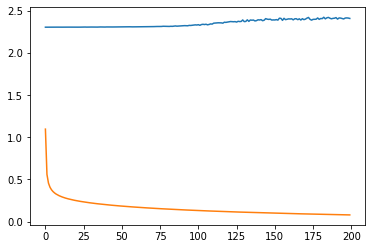

In [21]:
plt.plot(history_1)
plt.plot(history_2)

Pas de convergence sans préentrainement (ça sera surement la conclusion pour différents nombre de layers)

### Expérience 2

### Expérience 3

### Hyperparameter tuning